In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
#import keras
import pandas as pd

In [2]:
t = list(tf.compat.v1.python_io.tf_record_iterator('eval_laugh_speech_subset.tfrecord'))
tf_example = tf.train.Example.FromString(t[0])
tf_example.features.feature['video_id'].bytes_list.value[0].decode()

W0422 15:03:21.655379 139775741073216 deprecation.py:323] From <ipython-input-2-13334e7947c0>:1: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


'7oHaG3Ez5-4'

In [3]:
len(t)

240

In [4]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord):
    max_len=10
    records = list(tf.compat.v1.python_io.tf_record_iterator(tfrecord))
    rec_len = len(records)
    print(rec_len)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size 
    j = 0

    cheer_applause_labels = [66, 67] # change labels to cheer and applause
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            cheer_applause_bin = any((True for x in example_label if x in cheer_applause_labels))
            y.append(cheer_applause_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, y

Using TensorFlow backend.


In [73]:
import itertools
batch_size = 128
val_gen = data_generator(batch_size,'eval_laugh_speech_subset.tfrecord')
val = list(itertools.islice(val_gen,586//32))
X = [d[0] for d in val]
y = [d[1] for d in val]
X = np.concatenate(X)
y = np.concatenate(y)

240


In [75]:
X[1].shape

(10, 128)

In [10]:
from tensorflow.keras.models import load_model

# Simple Logistic Regression

In [44]:
m1 = load_model('../Models/cheer_applause_LR_100Epochs.h5')
p1 = m1.predict(X)

W0422 15:33:02.231436 139775741073216 hdf5_format.py:266] Sequential models without an `input_shape` passed to the first layer cannot reload their optimizer state. As a result, your model isstarting with a freshly initialized optimizer.


In [45]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresholds1 = roc_curve(y,p1)


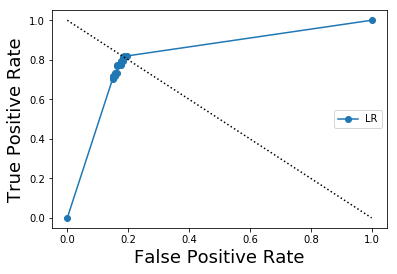

In [46]:
plt.plot(fpr1,tpr1, 'o-', label='LR')
plt.plot([0,1],[1,0],'k:')
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
plt.legend();

In [47]:
from sklearn.metrics import roc_auc_score
print(f'Logistic Regression: {roc_auc_score(y, p1):0.2f}')

Logistic Regression: 0.82


In [59]:
from sklearn.metrics import accuracy_score
print(f'Logistic Regression: {accuracy_score(y, p1.round()):0.2f}')

Logistic Regression: 0.81


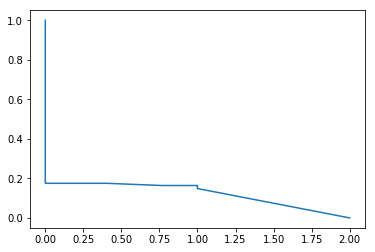

In [49]:
plt.plot(thresholds1,fpr1)

# LSTM 3 Layers

In [50]:
m2 = load_model('../Models/v2_cheer_applause_LSTM_ThreeLayer_100Epochs.h5')
p2 = m2.predict(X)

W0422 15:33:11.753634 139775741073216 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f1bee55c978>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0422 15:33:11.886897 139775741073216 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f1bee325828>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0422 15:33:12.023782 139775741073216 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f1bee1540f0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [51]:
from sklearn.metrics import roc_curve
fpr2, tpr2, thresholds2 = roc_curve(y,p2)


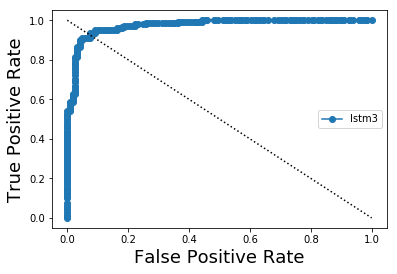

In [52]:
plt.plot(fpr2,tpr2, 'o-', label='lstm3')

plt.plot([0,1],[1,0],'k:')
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
plt.legend();

In [54]:
from sklearn.metrics import roc_auc_score
print(f'LSTM 3: {roc_auc_score(y, p2):0.2f}')

LSTM 3: 0.97


In [57]:
from sklearn.metrics import accuracy_score
print(f'LSTM 3: {accuracy_score(y, p2.round()):0.2f}')

LSTM 3: 0.93


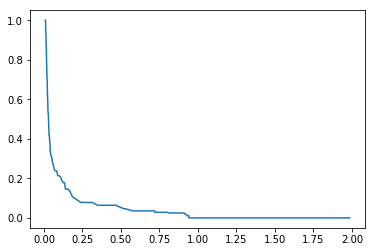

In [58]:
plt.plot(thresholds3,fpr3)

# Comparison of Logistic Regression vs 3-Layer LSTM

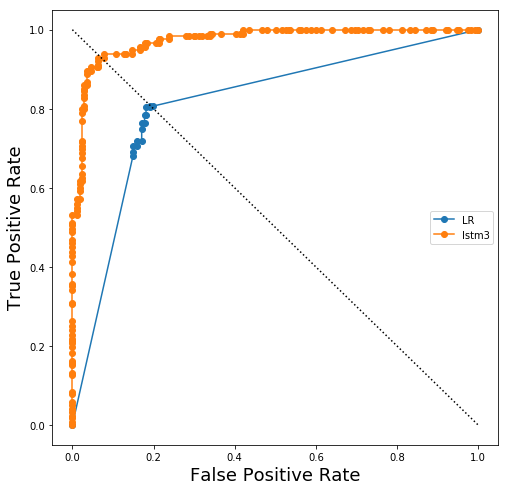

In [25]:
plt.figure(figsize=(8,8))
plt.plot(fpr1,tpr1, 'o-', label='LR')
plt.plot(fpr2,tpr2, 'o-', label='lstm3')
plt.plot([0,1],[1,0],'k:')
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
plt.legend();

In [60]:
from sklearn.metrics import f1_score, classification_report

In [61]:
print(classification_report(y, p2.round()))

              precision    recall  f1-score   support

       False       0.92      0.95      0.93      1171
        True       0.95      0.91      0.93      1133

   micro avg       0.93      0.93      0.93      2304
   macro avg       0.93      0.93      0.93      2304
weighted avg       0.93      0.93      0.93      2304



In [62]:
print(classification_report(y, p1.round()))

              precision    recall  f1-score   support

       False       0.79      0.84      0.81      1171
        True       0.82      0.77      0.80      1133

   micro avg       0.81      0.81      0.81      2304
   macro avg       0.81      0.81      0.81      2304
weighted avg       0.81      0.81      0.81      2304

